In [1]:
import pandas as pd
import mplfinance as mpf
from regime_detection import get_msm, identify_bull_bear_states, get_transition_counts
import numpy as np
from deeptime import markov
from utils import generate_ar_weights, indicator_signal
import random
import matplotlib.pyplot as plt

In [2]:
random.seed(42)

In [3]:
symbol = 'GESHIP'
df = pd.read_csv(f'../data/symbols/{symbol}.csv')
data = df[['date', 'returns']]
data['returns'] = data['returns']
data.describe()

/tmp/ipykernel_7479/2112785641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['returns'] = data['returns']


,returns
count,287.000000
mean,0.005723
std,0.054065
min,-0.169423
25%,-0.028926
50%,0.003525
75%,0.033907
max,0.221181


In [4]:
split = 0.7
train_data, test_data = data[:int(split*len(data))], data[int(split*len(data)):]
test_data = test_data.reset_index(drop=True)

<Axes: >

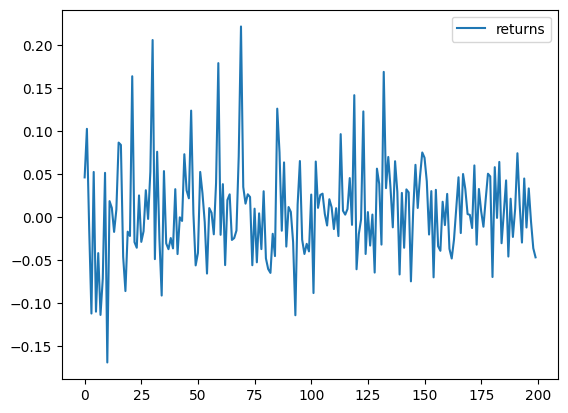

In [5]:
train_data.plot()

In [6]:
train_asset_states, train_stats = identify_bull_bear_states(train_data)

/home/aditya/markov-trading/src/regime_detection.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cumulative returns'] = (1 + df['returns']).cumprod() - 1
/home/aditya/markov-trading/src/regime_detection.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['State'] = states
/home/aditya/markov-trading/src/regime_detection.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [7]:
train_asset_states

,date,returns,Cumulative returns,State,Turning Point
0,2020-01-06 00:00:00+05:30,0.045733,0.045733,0,True
1,2020-01-13 00:00:00+05:30,0.102203,0.152610,0,False
2,2020-01-20 00:00:00+05:30,-0.013657,0.136868,0,False
3,2020-01-27 00:00:00+05:30,-0.112520,0.008948,0,False
4,2020-02-03 00:00:00+05:30,0.052061,0.061475,0,False
...,...,...,...,...,...
195,2023-10-02 00:00:00+05:30,-0.012512,1.772494,0,False
196,2023-10-09 00:00:00+05:30,0.032931,1.863795,0,False
197,2023-10-16 00:00:00+05:30,-0.005670,1.847556,0,False
198,2023-10-23 00:00:00+05:30,-0.036660,1.743165,0,False


In [8]:
train_stats

,State,mean,std
0,0,0.017008,0.056329
1,1,-0.007750,0.053682


In [9]:
mu_a, mu_b = train_stats.loc[0, 'mean'], train_stats.loc[1, 'mean']
sigma_a, sigma_b = train_stats.loc[0, 'std'], train_stats.loc[1, 'std']

In [10]:
test_data

,date,returns
0,2023-11-06 00:00:00+05:30,-0.013693
1,2023-11-13 00:00:00+05:30,0.003599
2,2023-11-20 00:00:00+05:30,0.059306
3,2023-11-27 00:00:00+05:30,0.051209
4,2023-12-04 00:00:00+05:30,0.027032
...,...,...
82,2025-06-02 00:00:00+05:30,0.058444
83,2025-06-09 00:00:00+05:30,0.004314
84,2025-06-16 00:00:00+05:30,-0.026884
85,2025-06-23 00:00:00+05:30,0.011372


In [11]:
test_asset_states, test_stats = identify_bull_bear_states(test_data)

In [12]:
test_stats

,State,mean,std
0,0,0.014410,0.049132
1,1,-0.007678,0.045456


In [13]:
transition_counts, total = get_transition_counts(train_asset_states)
transition_counts

[[0.9210526315789473, 0.07894736842105263],
 [0.09411764705882353, 0.9058823529411765]]

In [14]:
estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

true_msm = markov.msm.MarkovStateModel(transition_counts)
trajectory = true_msm.simulate(50000)
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="sliding"
)
counts = counts_estimator.fit(trajectory).fetch_model()
counts


TransitionCountModel-140145845967008:[{'count_matrix': array([[25499.,  2109.],
                                            [ 2108., 20283.]]),
                                      'count_matrix_full': array([[25499.,  2109.],
                                            [ 2108., 20283.]]),
                                      'counting_mode': 'sliding',
                                      'lagtime': 1,
                                      'state_histogram': array([27608, 22392]),
                                      'state_histogram_full': array([27608, 22392]),
                                      'state_symbols': array([0, 1])}]

In [15]:
regime_switching_model = estimator.fit(counts).fetch_model()
print("Estimated transition matrix:", regime_switching_model.transition_matrix)
print("Estimated stationary distribution:", regime_switching_model.stationary_distribution)

Estimated transition matrix: [[0.92360911 0.07639089]
 [0.09414498 0.90585502]]
Estimated stationary distribution: [0.55205381 0.44794619]


In [16]:
alpha, beta = regime_switching_model.transition_matrix[0][1], regime_switching_model.transition_matrix[1][0]

In [17]:
ar_weights = generate_ar_weights(alpha, beta, mu_a, mu_b, sigma_a, sigma_b, p=20)

pi_a =  0.5520538057975829
pi_b =  0.44794619420241705
sigma =  0.05651636128766726
c =  0.047454030872397156
phi =  0.8294641284772901
d =  1.026900015473218


In [18]:
ar_weights

[np.float64(0.04545907236575938),
 np.float64(0.03606709323964696),
 np.float64(0.028615524845975543),
 np.float64(0.02270347257456611),
 np.float64(0.018012867830259894),
 np.float64(0.014291355932655717),
 np.float64(0.01133871942649495),
 np.float64(0.008996106376372562),
 np.float64(0.007137484127696448),
 np.float64(0.005662858745970097),
 np.float64(0.004492895340022233),
 np.float64(0.0035646498424066623),
 np.float64(0.0028281826166257776),
 np.float64(0.002243871703141532),
 np.float64(0.0017802811567261324),
 np.float64(0.0014124697916359555),
 np.float64(0.0011206493450466987),
 np.float64(0.0008891198679010573),
 np.float64(0.0007054250671635837),
 np.float64(0.0005596821568699027),
 np.float64(0.0004440501639359903)]

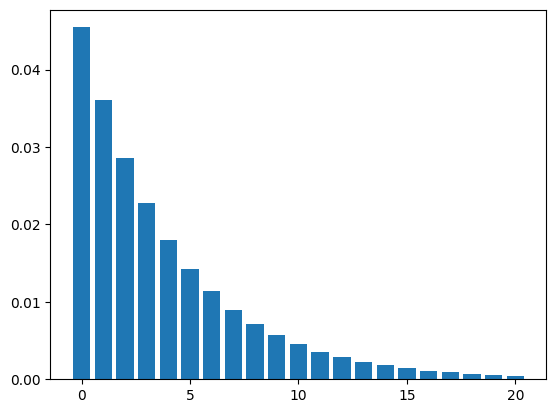

In [19]:
plt.figure()
plt.bar([i for i in range(0, len(ar_weights))], ar_weights)
plt.show()

In [20]:
len(train_data)

200

In [21]:
signals = []
for i in range(0, len(train_data)-20):
    signal = indicator_signal(ar_weights, np.asarray(train_data['returns'][i:i+20].reset_index(drop=True)), p=20, a=5)
    signals.append(signal)
signals

[np.float64(-0.012841082242811752),
 np.float64(-0.014451348887612151),
 np.float64(0.018016552593991944),
 np.float64(0.009220400412413418),
 np.float64(0.0006983457008998279),
 np.float64(0.0052674442273858086),
 np.float64(-0.000992204218094454),
 np.float64(-0.003584570704322546),
 np.float64(0.0028758713848472455),
 np.float64(0.0017084615920972073),
 np.float64(0.011163421694223033),
 np.float64(0.04586382854593012),
 np.float64(0.02747585576396436),
 np.float64(0.035464352586359764),
 np.float64(0.023464982276729402),
 np.float64(0.0019048764326633212),
 np.float64(0.010894142697579729),
 np.float64(0.003162964666646931),
 np.float64(-0.004098386379693551),
 np.float64(-0.007675952802235432),
 np.float64(-0.012675691362450767),
 np.float64(-0.004639224465483764),
 np.float64(-0.011440864269120887),
 np.float64(-0.009117406543477346),
 np.float64(-0.008171553694565108),
 np.float64(0.00668731352665275),
 np.float64(0.010869482904454653),
 np.float64(0.012421777054725405),
 np.flo

In [22]:
buy_dates = []
for i in range(0, len(signals)):
    if signals[i] > 0:
        buy_dates.append(train_data['date'][20+i-1])


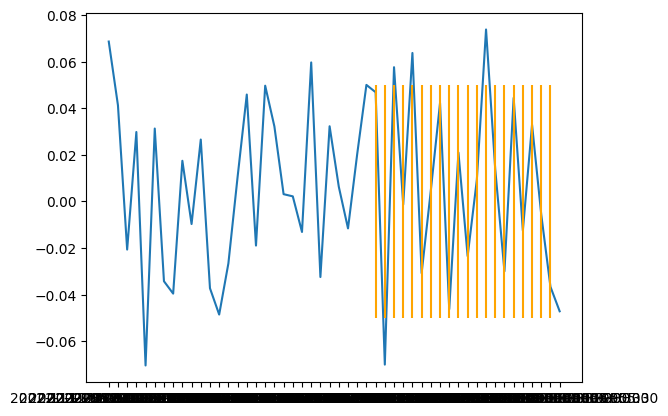

In [23]:
plt.figure()
plt.plot(train_data['date'][150:], train_data['returns'][150:])
plt.vlines(buy_dates[-20:], -0.05, 0.05, color='orange')
plt.show()

In [24]:
test_signals = []
for i in range(0, len(test_data)-20):
    t_signal = indicator_signal(ar_weights, np.asarray(train_data['returns'][i:i+20].reset_index(drop=True)), p=20, a=5)
    test_signals.append(t_signal)
test_signals

[np.float64(-0.012841082242811752),
 np.float64(-0.014451348887612151),
 np.float64(0.018016552593991944),
 np.float64(0.009220400412413418),
 np.float64(0.0006983457008998279),
 np.float64(0.0052674442273858086),
 np.float64(-0.000992204218094454),
 np.float64(-0.003584570704322546),
 np.float64(0.0028758713848472455),
 np.float64(0.0017084615920972073),
 np.float64(0.011163421694223033),
 np.float64(0.04586382854593012),
 np.float64(0.02747585576396436),
 np.float64(0.035464352586359764),
 np.float64(0.023464982276729402),
 np.float64(0.0019048764326633212),
 np.float64(0.010894142697579729),
 np.float64(0.003162964666646931),
 np.float64(-0.004098386379693551),
 np.float64(-0.007675952802235432),
 np.float64(-0.012675691362450767),
 np.float64(-0.004639224465483764),
 np.float64(-0.011440864269120887),
 np.float64(-0.009117406543477346),
 np.float64(-0.008171553694565108),
 np.float64(0.00668731352665275),
 np.float64(0.010869482904454653),
 np.float64(0.012421777054725405),
 np.flo

In [25]:
test_buy_dates = []
for i in range(0, len(test_signals)):
    if test_signals[i] > 0:
        test_buy_dates.append(test_data['date'][20+i-1])

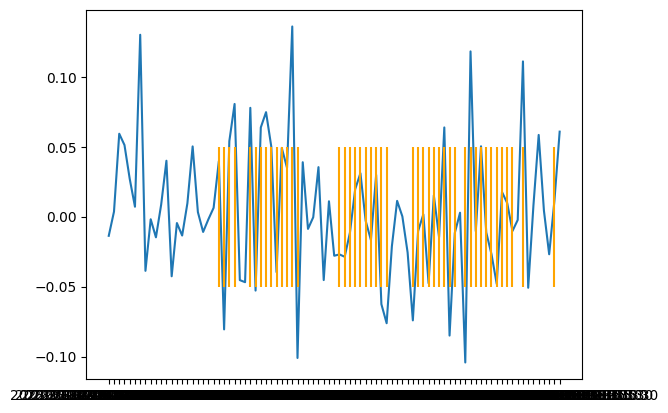

In [27]:
plt.figure()
plt.plot(test_data['date'], test_data['returns'])
plt.vlines(test_buy_dates, -0.05, 0.05, color='orange')
plt.show()